In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import shapiro, bartlett
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.libqsturng import qsturng


$$
\begin{aligned}
H_0: &\text{The box office of the movies of different genres are eqivalent.} \\
H_1: &\text{The box office of the movies of at least one genre is different from others.}
\end{aligned}
$$

In [6]:
# Load data
df = pd.read_csv('movie_summary.csv')

# Filter by production year and budget
filtered_df = df[
    # (df['production_year'] > 2000) & 
    (df['production_budget'] < 20000000) & 
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
]

# ---------------------------
# Shapiro-Wilk Normality Test (per genre group)
# ---------------------------
print("=== Shapiro-Wilk Test (Domestic Box Office per Genre) ===")
genre_groups = filtered_df.groupby('genre')['domestic_box_office']

for genre, values in genre_groups:
    if len(values) >= 3:  # Shapiro-Wilk requires at least 3 values
        stat, p = shapiro(values)
        print(f"Genre: {genre:<20} | W = {stat:.4f} | p = {p:.4f}")

# ---------------------------
# Bartlett's Test (Equal variances across genres)
# ---------------------------
# Collect lists of values per genre
grouped_values = [  group['domestic_box_office'].values 
                    for name, group in filtered_df.groupby('genre') 
                    if len(group) >= 3  ]

print("\n=== Bartlett's Test (Domestic Box Office across Genres) ===")
bartlett_stat, bartlett_p = bartlett(*grouped_values)
print(f"Bartlett's Test: stat = {bartlett_stat:.4f} | p = {bartlett_p:.4f}\n")

=== Shapiro-Wilk Test (Domestic Box Office per Genre) ===
Genre: Action               | W = 0.0908 | p = 0.0000
Genre: Adventure            | W = 0.1547 | p = 0.0000
Genre: Black Comedy         | W = 0.5019 | p = 0.0000
Genre: Comedy               | W = 0.2776 | p = 0.0000
Genre: Concert/Performance  | W = 0.1385 | p = 0.0000
Genre: Documentary          | W = 0.1219 | p = 0.0000
Genre: Drama                | W = 0.1676 | p = 0.0000
Genre: Horror               | W = 0.3471 | p = 0.0000
Genre: Multiple Genres      | W = 0.4667 | p = 0.0000
Genre: Musical              | W = 0.2913 | p = 0.0000
Genre: Reality              | W = 0.8887 | p = 0.3508
Genre: Romantic Comedy      | W = 0.2556 | p = 0.0000
Genre: Thriller/Suspense    | W = 0.3194 | p = 0.0000
Genre: Western              | W = 0.2683 | p = 0.0000

=== Bartlett's Test (Domestic Box Office across Genres) ===
Bartlett's Test: stat = 7270.3330 | p = 0.0000



c:\Users\User\Desktop\114Spring-Statistics(I)(2)\Statistics_Final_Project\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6392.
  res = hypotest_fun_out(*samples, **kwds)


In [7]:
# Welch's ANOVA for domestic box office
print("=== Welch's ANOVA: Domestic Box Office ===")
welch_domestic = pg.welch_anova(dv='domestic_box_office', between='genre', data=filtered_df)
print(welch_domestic)

print("\n=== Welch's ANOVA: International Box Office ===")
welch_international = pg.welch_anova(dv='international_box_office', between='genre', data=filtered_df)
print(welch_international)

=== Welch's ANOVA: Domestic Box Office ===
  Source  ddof1       ddof2          F         p-unc       np2
0  genre     13  473.760085  41.070579  3.051022e-69  0.013302

=== Welch's ANOVA: International Box Office ===
  Source  ddof1    ddof2          F         p-unc       np2
0  genre     13  220.612  50.563371  9.884201e-59  0.021073



=== Tukey HSD: Domestic Box Office ===
Q critical value = 4.743567
Tukey Omega = 7919516.750245
                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                       
       group1              group2          meandiff   p-adj      lower          upper     reject
------------------------------------------------------------------------------------------------
             Action           Adventure  1115414.4067 0.7669   -753331.9744  2984160.7877  False
             Action        Black Comedy  2142857.8181 0.7936  -1526882.5081  5812598.1443  False
             Action              Comedy   795295.2549 0.9095   -756091.5293   2346682.039  False
             Action Concert/Performance -1475959.5479 0.7199  -3863492.7826   911573.6867  False
             Action         Documentary -1660022.1899 0.0249  -3221583.0121   -98461.3677   True
             Action               Drama  -437052.1018 0.9992  -1884751.0412  1010646.8376  False
             Action           

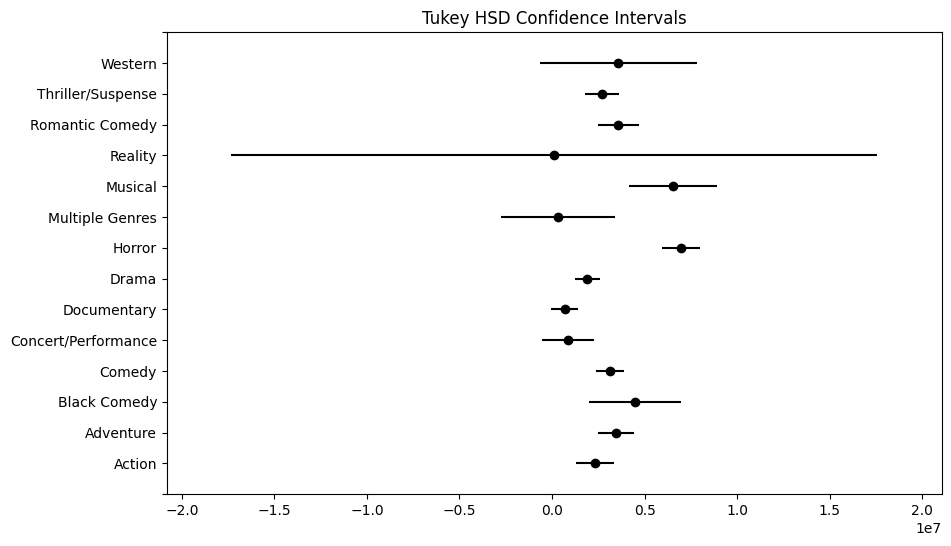


=== Tukey HSD: International Box Office ===
Q critical value = 4.743567
Tukey Omega = 14253693.228793
                       Multiple Comparison of Means - Tukey HSD, FWER=0.05                        
       group1              group2          meandiff    p-adj      lower          upper      reject
--------------------------------------------------------------------------------------------------
             Action           Adventure  -5955346.4081    0.0  -9318750.8276  -2591941.9887   True
             Action        Black Comedy -10637365.9555    0.0 -17242232.7029  -4032499.2082   True
             Action              Comedy  -9312225.4483    0.0 -12104440.1753  -6520010.7213   True
             Action Concert/Performance -14207036.9119    0.0  -18504163.539  -9909910.2849   True
             Action         Documentary -14365868.6198    0.0 -17176394.7692 -11555342.4705   True
             Action               Drama -11379663.4605    0.0 -13985258.8801  -8774068.0409   True
      

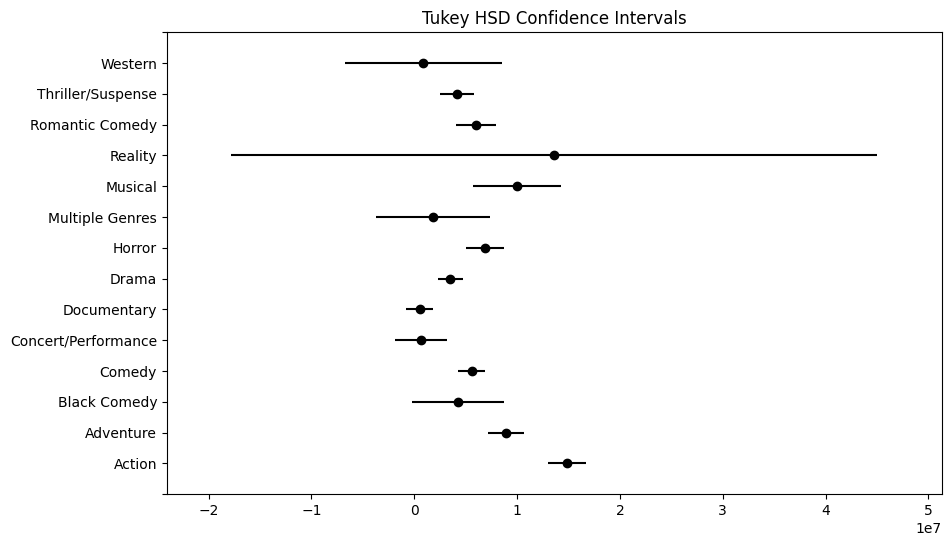

In [8]:
def tukey_hsd(df, response_col, factor_col, alpha=0.05, comparison_focus=None):
    group_sizes = df.groupby(factor_col).size()
    k = len(group_sizes)
    df_within = df.shape[0] - k

    ng = k / np.sum(1 / group_sizes)

    model = smf.ols(f"{response_col} ~ C({factor_col})", data=df).fit()
    aov_table = sms.anova_lm(model, typ=2)
    mse = aov_table.loc["Residual", "sum_sq"] / aov_table.loc["Residual", "df"]

    q_crit = qsturng(1 - alpha, k, df_within)
    omega = q_crit * np.sqrt(mse / ng)

    tukey = MultiComparison(df[response_col], df[factor_col])
    tukey_result = tukey.tukeyhsd(alpha=alpha)

    print(f"Q critical value = {q_crit:.6f}")
    print(f"Tukey Omega = {omega:.6f}")
    print(tukey_result.summary())

    # Plot overall CI
    _ = tukey_result.plot_simultaneous()
    plt.title("Tukey HSD Confidence Intervals")
    plt.show()

    # Optional: Focused plot on a specific group
    if comparison_focus:
        _ = tukey_result.plot_simultaneous(comparison_name=comparison_focus)
        plt.title(f"Tukey HSD Focused on: {comparison_focus}")
        plt.show()

    return tukey_result.summary(), omega

# Run Tukey HSD for domestic box office
print("\n=== Tukey HSD: Domestic Box Office ===")
summary_dom, omega_dom = tukey_hsd(filtered_df, 'domestic_box_office', 'genre')

# Run Tukey HSD for international box office
print("\n=== Tukey HSD: International Box Office ===")
summary_intl, omega_intl = tukey_hsd(filtered_df, 'international_box_office', 'genre')